In [2]:
from abc import ABC, abstractmethod
import numpy as np

In [5]:
class InterfaceEnvironment(ABC):
    
    @abstractmethod
    def __init__(self):
        pass
    
    @property
    @abstractmethod
    def states(self):
        """The representation of the state space"""
        pass
    
    
    @abstractmethod
    def step(self, action):
        """Takes a step. Uses action for the step"""
        pass
    
    @abstractmethod
    def reset(self):
        """resets environment. Defaults back to starting period. 
        reset method also can take a state (used for solving the model)"""
        pass
    
    

In [16]:
class EnvironmentModel1(InterfaceEnvironment):
    
    """
    Ordering of items
    states: Q, M, K, W
    shocks: epsilon, rho, gamma
    """
    
    DEFAULT_AGE = 18
    DEFAULT_CASH_ON_HAND = 500
    DEFAULT_KIDS = 0
    DEFAULT_WAGE = 120
    
    def __init__(self, kappa, mu_rho, sigma_rho, p_gamma, sigma_epsilon, a, b, c, d):
        
        #parameters
        self.kappa = kappa
        self.mu_rho = mu_rho
        self.sigma_rho = sigma_rho
        self.p_gamma = p_gamma
        self.sigma_epsilon = sigma_epsilon
        
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
        #states
        self.age = self.DEFAULT_AGE
        self.cash_on_hand = self.DEFAULT_CASH_ON_HAND
        self.kids = self.DEFAULT_KIDS
        self.wage = self.DEFAULT_WAGE
        
    def __repr__(self):
        return f"(Q: {self.age}, M: {self.cash_on_hand}, K: {self.kids}, W: {self.wage})"
    
    def reset(self, states=None):
        if states is None:
            age, cash_on_hand, kids, wage = states[0], states[1], states[2], states[3]
            self.age = age
            self.cash_on_hand = cash_on_hand
            sef.kids = kids
            self.wage = wage
        else:
            self.age = self.DEFAULT_AGE
            self.cash_on_hand = self.DEFAULT_CASH_ON_HAND
            self.kids = self.DEFAULT_KIDS
            self.wage = self.DEFAULT_WAGE
        
    def step(self, action, shocks=None):
        if shocks is None:
            shocks = self.draw_shocks()
    
        ### transitions
        self.calc_age()
        self.calc_wage()
        
        # necessary for cash_on_hand
        salary = self.calc_salary(action)

        self.calc_cash_on_hand(salary, shocks[1])
        self.calc_kids(shocks[2])
        
        ### model dynamic
        leisure = self.calc_leisure()
        alpha = self.calc_alpha()
        consumption = self.calc_consumption()
        assets = self.calc_assets(consumption)
        
        utility = self.calc_utility(consumption, leisure, alpha)

    @property
    def states(self):
        return self.age, self.cash_on_hand, self.kids, self.wage
    
    
    #model dynamic
    def calc_utility(self, consumption, leisure, alpha):
        return consumption**(1 - alpha) * leisure**(alpha)
    
    def calc_alpha(self):
        return self.f_alpha()
    
    def calc_assets(self, consumption):
        return self.cash_on_hand - consumption
    
    def calc_salary(self, hours):
        return hours * self.wage
    
    def calc_consumption(self):
        return self.kappa * self.cash_on_hand
    
    def calc_leisure(self, hours):
        return 7 * 24 - hours
    
    def calc_dies(self):
        # stops the model (returns done flag)
        if self.age > 85:
            return True
        return False
    
    # transitions (L.O.M)
    def calc_cash_on_hand(self, salary, rho):
        self.cash_on_hand = rho * self.assets + salary
    
    def calc_kids(self, gamma):
        if self.kids < 5:
            self.kids = self.kids + gamma
    
    def calc_wage(self, epsilon):
        self.wage = self.wage * self.f_w() * epsilon
    
    def calc_age(self):
        self.age = age + 1
    
    # def shocks
    def draw_shocks(self):
        return (self.draw_epsilon(), self.draw_rho(), self.draw_gamma())
        
    def draw_epsilon(self):
        return np.exp(np.random.lognormal(0, self.sigma_epsilon))
    
    def draw_rho(self):
        return np.random.normal(self.mu_rho, self.sigma_rho)
    
    def draw_gamma(self):
        return np.random.binomial(1,self.p_gamma)
            
    
    # function
    def f_alpha(self):
        _exp = np.exp(self.c + self.d*self.kids)
        self.a + self.b* ( _exp / (1 + _exp))
    
    def f_w(self):
        # should be changed when data is available for the permanint income structure of the income dynamic
        self.age * 1

In [17]:
parameters = {
    'kappa' : 0.5, 
    'mu_rho' : 0.06, 
    'sigma_rho' : 0.12, 
    'p_gamma' : 0.3, 
    'sigma_epsilon' : 3, 
    'a' : 0.3, 
    'b' : 0.3, 
    'c' : -2, 
    'd' : 1.5
}

In [18]:
env = EnvironmentModel1(**parameters)

In [19]:
env.step(37)

NameError: name 'assets' is not defined

In [74]:
def f_alpha_(a, b, c, d, K):

    _exp = np.exp(c + d* K)
    return a +b* ( _exp / (1 + _exp))
    

In [75]:
import matplotlib.pyplot as plt

In [80]:
K_list = [K for K in range(0,6)]
alphas = [f_alpha_(a=0.3, b=0.3, c=-2, d=1.5, K=K) for K in K_list]

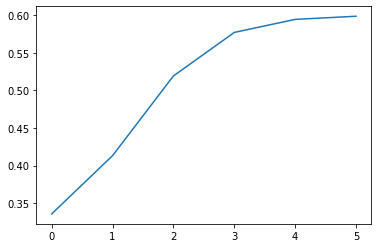

In [81]:
plt.plot(K_list, alphas)

In [130]:
draws = list()
for i in range(100000):
    draws.append(np.random.binomial(1,0.5))

In [131]:
np.mean(draws)

0.50177